In [1]:
import numpy as np
import pandas as pd

In [2]:
class Node():
    def __init__(self, ftr_index=None, threshold=None, dataleft=None, dataright=None, info_gain=None, value=None):
        self.feature_index = ftr_index
        self.threshold = threshold
        self.dataleft = dataleft
        self.dataright = dataright
        self.info_gain = info_gain
        self.value = value

In [3]:
class DecisionTree():
    def __init__(self, min_split=2, max_depth=2):
        self.root = None
        self.min_split = min_split #when to stop splitting (ex: if 2 samples left in node, stop splitting)
        self.max_depth = max_depth #maximum depth of tree
        
    def make_tree(self, data, curr_depth=0):

        X, y = data[:,:-1], data[:,-1] #last column is y
        nb_samples, _ = np.shape(X)
        
        if nb_samples>=self.min_split and curr_depth<=self.max_depth: 
            #if we have enough samples to split and haven't reached max depth
            bestsplit = self.best_split(X,y)

            if bestsplit["info_gain"]>0: 
                #do the split only if the info gain is positive
                left = self.make_tree(bestsplit["data_left"], curr_depth+1)
                right = self.make_tree(bestsplit["data_right"], curr_depth+1)
   
                return Node(bestsplit["feature_index"], bestsplit["threshold"], 
                            left, right, bestsplit["info_gain"])


        y=list(y)
        leaf_val=max(y, key=y.count)

        return Node(value=leaf_val)
    
    def best_split(self, X, y):

        best_split = {}
        best_info_gain = -np.inf 
        features = X.shape[1] 
        
        for feature in range(features):
            feature_values = X[:, feature]

            for threshold in np.unique(feature_values):
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                #divide the current node into two child nodes based on the threshold
                left = np.array([row for row in df if row[feature] <= threshold])
                right = np.array([row for row in df if row[feature] > threshold])
                #if the split is valid, calculate the info gain
                if len(left) > 0 and len(right) > 0:
                    y = df[:, -1]
                    yleft = left[:, -1]
                    yright = right[:, -1]

                    current_info_gain = self.infogain(y, yleft, yright)
                    #if the info gain for this treshold is better than the current info gain, update it
                    if current_info_gain > best_info_gain:
                        best_split = {
                            'feature_index': feature,
                            'threshold': threshold,
                            'data_left': left,
                            'data_right': right,
                            'info_gain': current_info_gain
                        }
                        best_info_gain = current_info_gain
        return best_split
    
    def infogain(self, parent, leftchild, rightchild):
        
        leftweight = len(leftchild) / len(parent)
        rightweight = len(rightchild) / len(parent)
        return self.entropy(parent) - (leftweight*self.entropy(leftchild) 
                + rightweight*self.entropy(rightchild)) 

    
    def entropy(self, y):
        entropy = 0
        labels = np.unique(y)
        
        for label in labels:
            label_prob = len(y[y == label]) / len(y)
            entropy += -label_prob * np.log2(label_prob)
        return entropy

        

    def fit(self, X, y):
        data = np.concatenate((X, y), axis=1)
        self.root = self.make_tree(data)
    
    def predict(self, X):
        predictions = [self.predict_sample(x, self.root) for x in X]
        return predictions
    
    def predict_sample(self, x, tree):
        #predicts the value of a single sample
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.predict_sample(x, tree.dataleft)
        elif feature_val>tree.threshold:
            return self.predict_sample(x, tree.dataright)

In [4]:
dataset=np.load('data/fashion_train.npy')
X,y=np.hsplit(dataset, [-1])

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# # Scale the data
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

# Perform PCA
pca = PCA(n_components=15)
X_train_reduced = pca.fit_transform(X_scaled)

# Train the model

classifier = DecisionTree(min_split=2, max_depth=5)
classifier.fit(X_train_reduced,y)

In [ ]:
# Load and standardize test data
testdata=np.load('data/fashion_test.npy')

X_test, y_test = np.hsplit(testdata, [-1])

X_scaled = scaler.transform(X_test)

# Perform PCA
X_reduced = pca.transform(X_scaled)

Y_pred = classifier.predict(X_reduced) 

from sklearn.metrics import accuracy_score
accuracy_score(y_test, Y_pred)

0.7546

Text(0.5, 15.0, 'Predicted label')

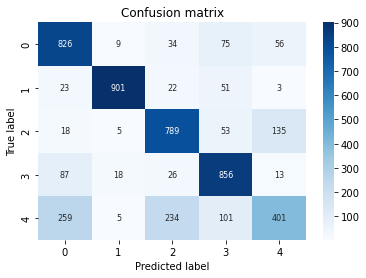

In [ ]:
#Plot the confusion matrix

import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sn.heatmap(confusion_matrix(y_test, Y_pred), annot=True, cmap='Blues', fmt='g', annot_kws={"size": 8})
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
#Make the classification report
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, auc, roc_auc_score, roc_curve

print("Accuracy: ", accuracy_score(y_test, Y_pred))
print("Precision: ", precision_score(y_test, Y_pred, average='macro'))
print("Recall: ", recall_score(y_test, Y_pred, average='macro'))
print("F1: ", f1_score(y_test, Y_pred, average='macro'))


Accuracy:  0.7546
Precision:  0.7537196854891663
Recall:  0.7545999999999999
F1:  0.7452441159348435
